In [1]:
import os
import os.path as op
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
%matplotlib inline
import seaborn as sns
sns.set_theme(style="darkgrid", color_codes=True)
sns.set(font_scale=1.35, style="ticks") #set styling preferences
import statsmodels.api as sm
from scipy import stats
import math
from math import pi
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype
from scipy.spatial.distance import cdist
from scipy.cluster.vq import kmeans2,vq, whiten
import sidetable

In [2]:
# Show all columns and rows
pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [3]:
# Showing the entire number in dataframe
pd.set_option('float_format', '{:f}'.format)

In [4]:
cols_to_use = ['IDMerged', 'tripIndex', 'actStartTime', 'actEndTime','duration_travelling', 'cost_BEAM', 'actStartType', 
               'actEndType', 'duration_walking', 'duration_in_privateCar', 'duration_on_bike', 'duration_in_ridehail', 
              'distance_travelling', 'duration_in_transit', 'distance_walking','distance_bike','distance_ridehail', 
              'distance_privateCar', 'distance_transit', 'mode_choice_planned_BEAM','mode_choice_actual_BEAM', 'vehicleIds',
              'numPassengers', 'distance_mode_choice', 'replanning_status', 'reason', 'parkingType',
               'BlockGroupStart','startX', 'startY', 'bgid_start', 'tractid_start', 'juris_name_start', 'county_name_start', 'mpo_start', 
               'BlockGroupEnd', 'endX', 'endY', 'bgid_end', 'tractid_end', 'juris_name_end', 'county_name_end', 'mpo_end',  
               'duration_door_to_door', 'waitTime_no_replanning', 'waitTime_replanning', 'actPurpose', 
               'mode_choice_actual_6', 'mode_choice_actual_5', 'mode_choice_actual_4', 
               'trip_id','person_id','household_id','tour_id','primary_purpose_x','destination_logsum_x', 'trip_mode_AS_trips', 
               'logsum_trip_Potential_INEXUS', 'tour_mode_AS_tours','duration','earning','sex','race_id', 'race',
               'TAZ_x','home_x','home_y','home_taz','value_of_time', 'school_taz','workplace_taz', 'free_parking_at_work',
               'hh_size','hh_income','income_in_thousands','median_value_of_time', 'hh_value_of_time', 'home_is_urban',
               'home_is_rural', 'auto_ownership','age', 'income', 'hh_cars', 'origin_x', 
               'destination_x', 'TAZ_y', 'DRIVEALONEFREE', 'scenario', 'year', 'lever_position_price', 
               'lever_position_fleetsize', 'door_to_door_time_relative_to_baseline', 'mandatoryCat', 'tour_category',
               'DRIVEALONEPAY', 'SHARED2FREE', 'SHARED2PAY', 'SHARED3FREE', 'SHARED3PAY', 'WALK', 'BIKE', 'WALK_LOC', 'WALK_LRF', 
               'WALK_EXP', 'WALK_HVY', 'WALK_COM', 'DRIVE_LOC', 'DRIVE_LRF', 'DRIVE_EXP', 'DRIVE_HVY', 'DRIVE_COM', 'TAXI',
               'TNC_SINGLE', 'TNC_SHARED', 'income_quartiles', 'income_deciles'] # Specify the columns to read

In [5]:
#%%time
# Original stacked file
#stacked_rh_path = "https://beam-core-act.s3.amazonaws.com/deepDive/CleanData/SanFrancisco/Stacked/"
#sf_stacked_rh_price_orig = pd.read_csv(stacked_rh_path + 'sf_2018_stacked_rh_price_5_5_23.csv', usecols = cols_to_use) #usecols = cols_to_use

In [6]:
%%time
# Stacked File without outliers (removed by isolation forest)
stacked_rh_path = "https://beam-core-act.s3.amazonaws.com/deepDive/CleanData/SanFrancisco/Stacked/"
sf_stacked_rh_price = pd.read_csv(stacked_rh_path + 'sf_2018_stacked_rh_price_clean_ML_5_11_23.csv') #usecols = cols_to_use

<timed exec>:3: DtypeWarning: Columns (25) have mixed types. Specify dtype option on import or set low_memory=False.


CPU times: total: 12min 54s
Wall time: 51min 48s


In [9]:
# remove the outliers
sf_stacked_rh_price = sf_stacked_rh_price[(sf_stacked_rh_price['duration_travelling'] > 0)].reset_index(drop=True)

In [10]:
# Remove the outliers
sf_stacked_rh_price = sf_stacked_rh_price[(sf_stacked_rh_price['duration_walking'] < 3600)&(sf_stacked_rh_price['distance_walking'] < 5000)]

#### Figure 5 - Density plot of the Potential INEXUS and income level

In [11]:
# We only chose three scenarios for this plot to show the differences more clearly
plot_inc_3 = sf_stacked_rh_price[(sf_stacked_rh_price['lever_position_price'] == 0)|
                         (sf_stacked_rh_price['lever_position_price'] == 1)|(sf_stacked_rh_price['lever_position_price'] == 8)]

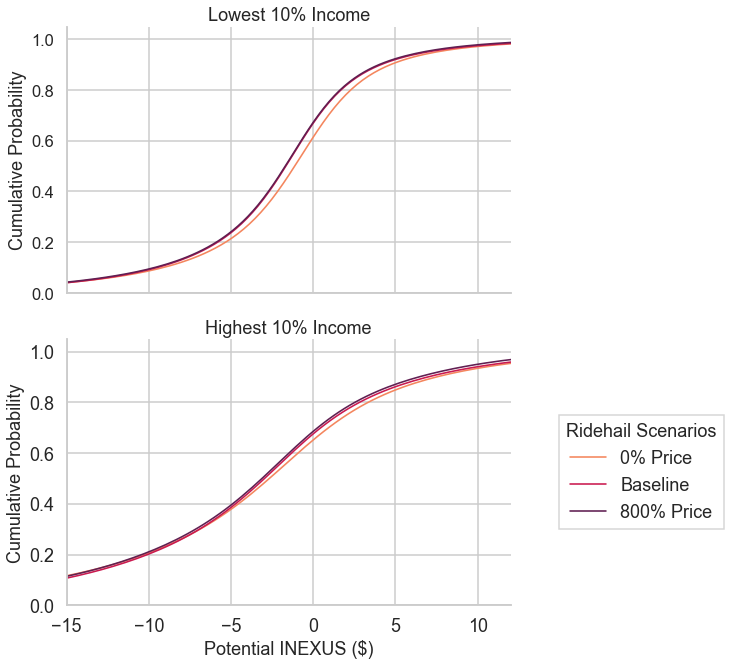

In [13]:
##### sns.set(rc={'figure.figsize':(20,14)}) # same mode cleaned data
sns.set_context('talk')
sns.set_style("whitegrid", {'gridcolor': 'grainsboro'})
grid = sns.FacetGrid(plot_inc_3.loc[(plot_inc_3['income_deciles'] == '1stD')|
                                    (plot_inc_3['income_deciles'] == '10thD')],
                     row = 'income_deciles',
                     hue='lever_position_price', height=5, aspect=1.5, palette = "rocket_r", legend_out=True )
grid.map(sns.kdeplot, 'Potential_INEXUS_in_dollar_2023', bw_adjust =3, linewidth = 1.6, cumulative=True)
#grid.set(xlim=(14, sf_stacked_rh_price['Realized_INEXUS_in_dollar'].max()), ylim=(0,0.06))
#grid.add_legend()

for ax, title in zip(grid.axes.flat, ['Lowest 10% Income','Highest 10% Income']):
    ax.set_title(title)

grid.set(xlim=(-15,12))

plt.legend(title="Ridehail Scenarios", labels = ['0% Price','Baseline','800% Price'],
         fontsize='small', fancybox=False, bbox_to_anchor=(1.5, 0.5), ncol=1, frameon=True, loc = 'right', prop={'size': 18})
grid.set_ylabels('Cumulative Probability', size=18)
grid.set_xlabels('Potential INEXUS ($)', size=18)
ax.yaxis.set_tick_params(labelsize = 18)
ax.xaxis.set_tick_params(labelsize = 18)
# Squash down a little and add title to facetgrid    
plt.subplots_adjust(top=0.9)

#grid.fig.suptitle('Realized INEXUS in dollar across income levels in different lever positions')
#plt.savefig('potential_income_2023.svg', dpi = 300, bbox_extra_artists=(ax.legend(['0% Price', '12.5% Price', '25% Price','50% Price','Baseline','175% Price','300% Price', '500% Price','800% Price'], bbox_to_anchor=(1.4, 0.7), ncol=1, frameon=True, loc = 'right', fontsize=18),), bbox_inches='tight')
#plt.savefig('potential_income_2023.png', dpi = 300, bbox_extra_artists=(ax.legend(['0% Price', '12.5% Price', '25% Price','50% Price','Baseline','175% Price','300% Price', '500% Price','800% Price'], bbox_to_anchor=(1.4, 0.7), ncol=1, frameon=True, loc = 'right', fontsize=18),), bbox_inches='tight')

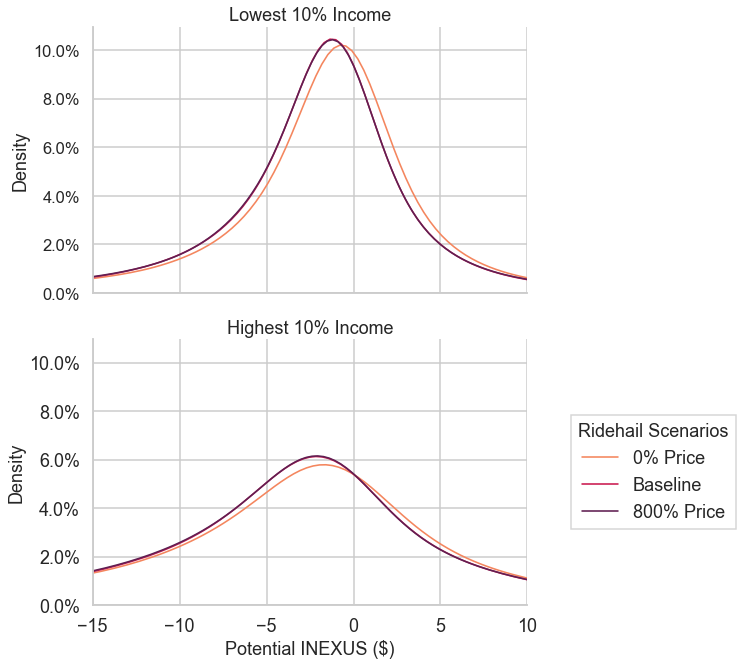

In [14]:
from matplotlib.ticker import FuncFormatter
sns.set(rc={'figure.figsize':(20,14)}) # same mode cleaned data   
sns.set_context('talk')
sns.set_style("whitegrid", {'gridcolor': 'grainsboro'})
grid = sns.FacetGrid(plot_inc_3.loc[(plot_inc_3['income_deciles'] == '1stD')|
                                    (plot_inc_3['income_deciles'] == '10thD')], 
                     row = 'income_deciles', col_order=['10thD', '1stD'],
                     hue='lever_position_price', height=5, aspect=1.5, palette = "rocket_r", legend_out=True )
grid.map(sns.kdeplot, 'Potential_INEXUS_in_dollar_2023', bw_adjust =3, linewidth = 1.6)
#grid.set(xlim=(14, sf_stacked_rh_price['Realized_INEXUS_in_dollar'].max()), ylim=(0,0.06))
#grid.add_legend()

# Define function to format y-axis labels as percentages
def to_percent(y, position):
    return "{:.1f}%".format(y * 100)

for ax, title in zip(grid.axes.flat, ['Lowest 10% Income','Highest 10% Income']):
    ax.set_title(title)

grid.set(xlim=(-15,10))

# Format y-axis labels as percentages
formatter = FuncFormatter(to_percent)
ax.yaxis.set_major_formatter(formatter)

plt.legend(title="Ridehail Scenarios", labels = ['0% Price', 'Baseline','800% Price'],
           #'0% Price', '12.5% Price', '25% Price','50% Price','Baseline','175% Price','300% Price', '500% Price','800% Price'
         fontsize='small', fancybox=False, bbox_to_anchor=(1.5, 0.5), ncol=1, frameon=True, loc = 'right', prop={'size': 18})
grid.set_ylabels('Density', size=18)
grid.set_xlabels('Potential INEXUS ($)', size=18)
ax.yaxis.set_tick_params(labelsize = 18)
ax.xaxis.set_tick_params(labelsize = 18)
# Squash down a little and add title to facetgrid    
plt.subplots_adjust(top=0.9)
#grid.fig.suptitle('Realized INEXUS in dollar across income levels in different lever positions')
#plt.savefig('potential_income_2023.svg', dpi = 300, bbox_extra_artists=(ax.legend(['0% Price', '12.5% Price', '25% Price','50% Price','Baseline','175% Price','300% Price', '500% Price','800% Price'], bbox_to_anchor=(1.4, 0.7), ncol=1, frameon=True, loc = 'right', fontsize=18),), bbox_inches='tight')
#plt.savefig('potential_income_2023.png', dpi = 300, bbox_extra_artists=(ax.legend(['0% Price', '12.5% Price', '25% Price','50% Price','Baseline','175% Price','300% Price', '500% Price','800% Price'], bbox_to_anchor=(1.4, 0.7), ncol=1, frameon=True, loc = 'right', fontsize=18),), bbox_inches='tight')

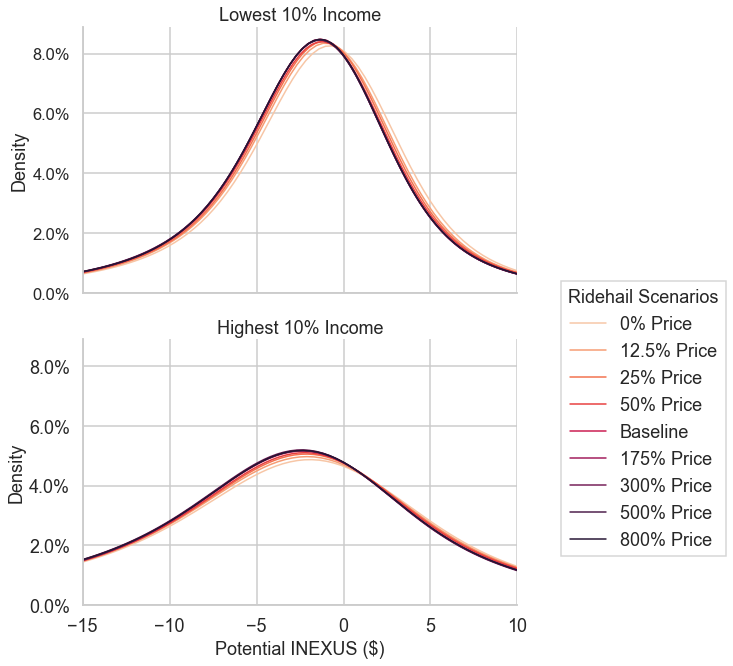

In [40]:
from matplotlib.ticker import FuncFormatter
sns.set(rc={'figure.figsize':(20,14)}) # same mode cleaned data   
sns.set_context('talk')
sns.set_style("whitegrid", {'gridcolor': 'grainsboro'})
grid = sns.FacetGrid(plot_inc.loc[(plot_inc['income_deciles'] == '1stD')|
                                    (plot_inc['income_deciles'] == '10thD')], 
                     row = 'income_deciles', col_order=['10thD', '1stD'],
                     hue='lever_position_price', height=5, aspect=1.5, palette = "rocket_r", legend_out=True )
grid.map(sns.kdeplot, 'Potential_INEXUS_in_dollar_2023', bw_adjust =5, linewidth = 1.5)
#grid.set(xlim=(14, sf_stacked_rh_price['Realized_INEXUS_in_dollar'].max()), ylim=(0,0.06))
#grid.add_legend()

# Define function to format y-axis labels as percentages
def to_percent(y, position):
    return "{:.1f}%".format(y * 100)

for ax, title in zip(grid.axes.flat, ['Lowest 10% Income','Highest 10% Income']):
    ax.set_title(title)

grid.set(xlim=(-15,10))

# Format y-axis labels as percentages
formatter = FuncFormatter(to_percent)
ax.yaxis.set_major_formatter(formatter)

plt.legend(title="Ridehail Scenarios", labels = ['0% Price', '12.5% Price', '25% Price','50% Price','Baseline','175% Price','300% Price', '500% Price','800% Price'],
         fontsize='small', fancybox=False, bbox_to_anchor=(1.5, 0.7), ncol=1, frameon=True, loc = 'right', prop={'size': 18})
grid.set_ylabels('Density', size=18)
grid.set_xlabels('Potential INEXUS ($)', size=18)
ax.yaxis.set_tick_params(labelsize = 18)
ax.xaxis.set_tick_params(labelsize = 18)
# Squash down a little and add title to facetgrid    
plt.subplots_adjust(top=0.9)
#grid.fig.suptitle('Realized INEXUS in dollar across income levels in different lever positions')
#plt.savefig('potential_income_2023.svg', dpi = 300, bbox_extra_artists=(ax.legend(['0% Price', '12.5% Price', '25% Price','50% Price','Baseline','175% Price','300% Price', '500% Price','800% Price'], bbox_to_anchor=(1.4, 0.7), ncol=1, frameon=True, loc = 'right', fontsize=18),), bbox_inches='tight')
#plt.savefig('potential_income_2023.png', dpi = 300, bbox_extra_artists=(ax.legend(['0% Price', '12.5% Price', '25% Price','50% Price','Baseline','175% Price','300% Price', '500% Price','800% Price'], bbox_to_anchor=(1.4, 0.7), ncol=1, frameon=True, loc = 'right', fontsize=18),), bbox_inches='tight')

#### Figure 6 and  7 - Boxplot INEXUS relative to baseline

In [26]:
sf_stacked_rh_price["mode_actual_baseline"] = np.where(sf_stacked_rh_price['lever_position']==1, sf_stacked_rh_price["mode_choice_actual_BEAM"], None)

In [27]:
sf_stacked_rh_price["mode_actual_baseline"] = sf_stacked_rh_price.groupby(['IDMerged','tripIndex'])['mode_actual_baseline'].transform(lambda x: x.ffill().bfill())

In [28]:
#sf_stacked_rh_price["mode_planned_baseline"] = np.where(sf_stacked_rh_price['lever_position']==1, sf_stacked_rh_price["mode_choice_planned_BEAM"], None)
#sf_stacked_rh_price["mode_planned_baseline"] = sf_stacked_rh_price.groupby(['IDMerged','tripIndex'])['mode_planned_baseline'].transform(lambda x: x.ffill().bfill())
#same_mode_planned = sf_stacked_rh_price[sf_stacked_rh_price['mode_planned_baseline'] == sf_stacked_rh_price['mode_choice_planned_BEAM']]
#diff_mode_planned = sf_stacked_rh_price[sf_stacked_rh_price['mode_planned_baseline'] != sf_stacked_rh_price['mode_choice_planned_BEAM']]

In [29]:
same_mode_actual = sf_stacked_rh_price[sf_stacked_rh_price['mode_actual_baseline'] == sf_stacked_rh_price['mode_choice_actual_BEAM']]

In [30]:
diff_mode_actual = sf_stacked_rh_price[sf_stacked_rh_price['mode_actual_baseline'] != sf_stacked_rh_price['mode_choice_actual_BEAM']]

In [34]:
#PRGn   PiYG  PuOr RdBu  RdGy_r RdYlBu  RdYlGn  YlGnBu   mako  BuGn YlGn_r 

CPU times: total: 2min 24s
Wall time: 2min 24s


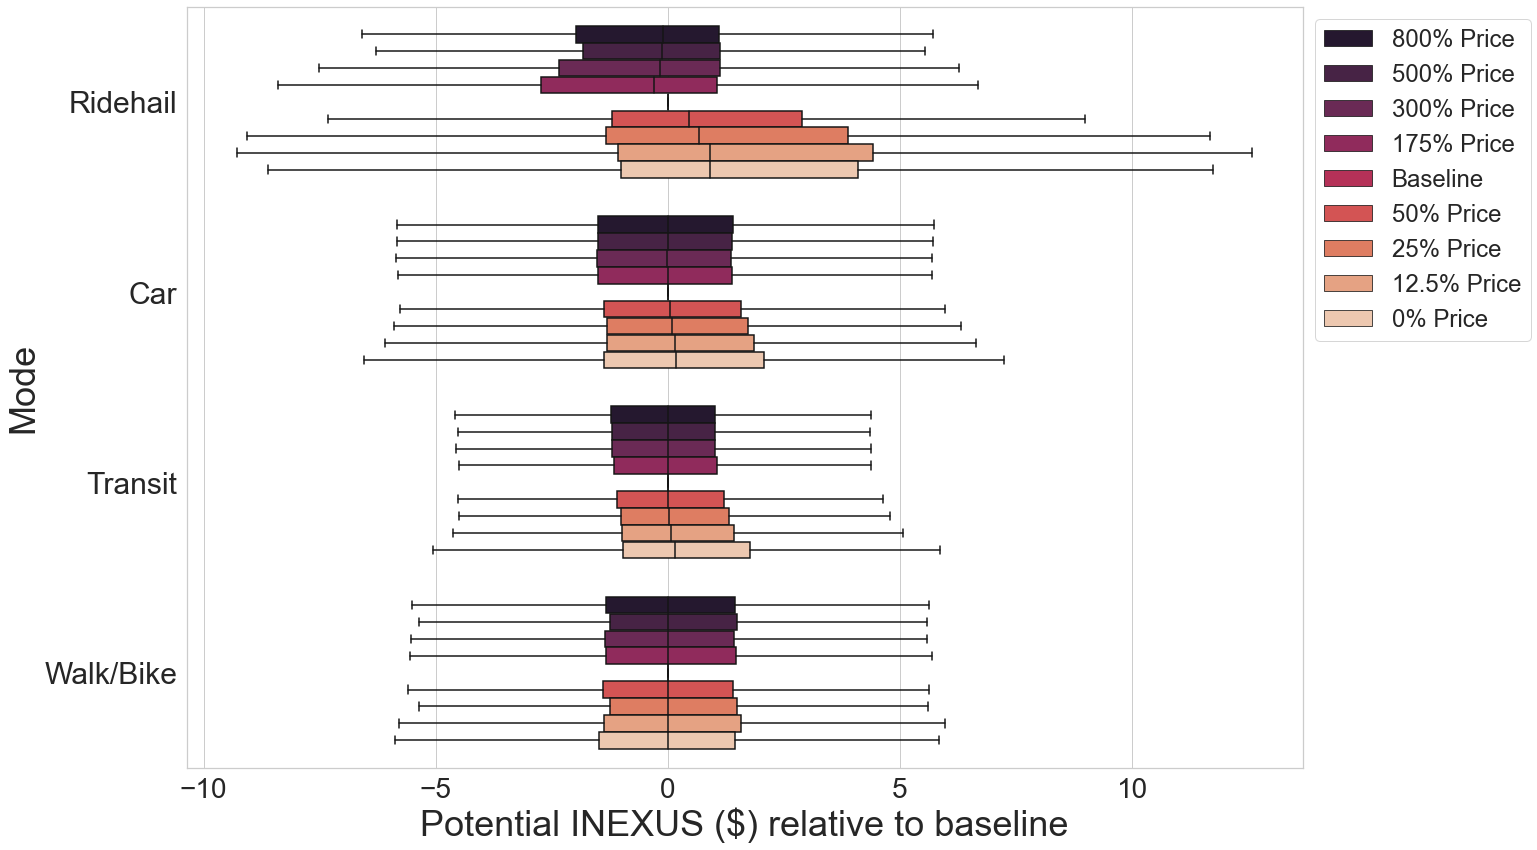

In [32]:
%%time
sns.set(rc={'figure.figsize':(20,14)})
sns.set_style("whitegrid", {'gridcolor': 'grainsboro'})
ax = sns.boxplot(x="potential_in_dollar_2023_relative_to_baseline", y="mode_choice_actual_4", order=["ride_hail","car","transit","walk/bike"], 
                 hue="lever_position_price", hue_order = [8, 5, 3, 1.75, 1, 0.5, 0.25, 0.125, 0],
                 data=same_mode_actual, palette="rocket", showfliers=False)
ax.set_xlabel('Potential INEXUS ($) relative to baseline', fontsize = 36)
ax.set_ylabel('Mode', fontsize = 36)
ax.xaxis.set_tick_params(labelsize = 28)
ax.set_yticklabels(['Ridehail', 'Car','Transit','Walk/Bike'], size = 30)
handles, _ = ax.get_legend_handles_labels()
# Specify the order of the levels in the hue variable
hue_order = ['800% Price', '500% Price', '300% Price', '175% Price', 'Baseline', '50% Price', '25% Price', '12.5% Price', '0% Price']
# Create a dictionary that maps the levels of the hue variable to the corresponding colors in the palette
palette_dict = dict(zip(hue_order, sns.color_palette("rocket", n_colors=len(hue_order))))
# Create a new list of handles that corresponds to the order of the labels in the legend
handles = [handles[hue_order.index(label)] for label in hue_order]
# Use the new list of handles and the dictionary of colors to create the legend
ax.legend(handles, hue_order, loc="upper left", prop={'size': 24}, markerscale=3, fontsize=24, bbox_to_anchor=(1, 1))
plt.savefig('box_sameMode_potential_2023.svg', bbox_inches='tight', dpi=300)
plt.savefig('box_sameMode_potential_2023.png', bbox_inches='tight', dpi = 300)

CPU times: total: 2min 20s
Wall time: 2min 20s


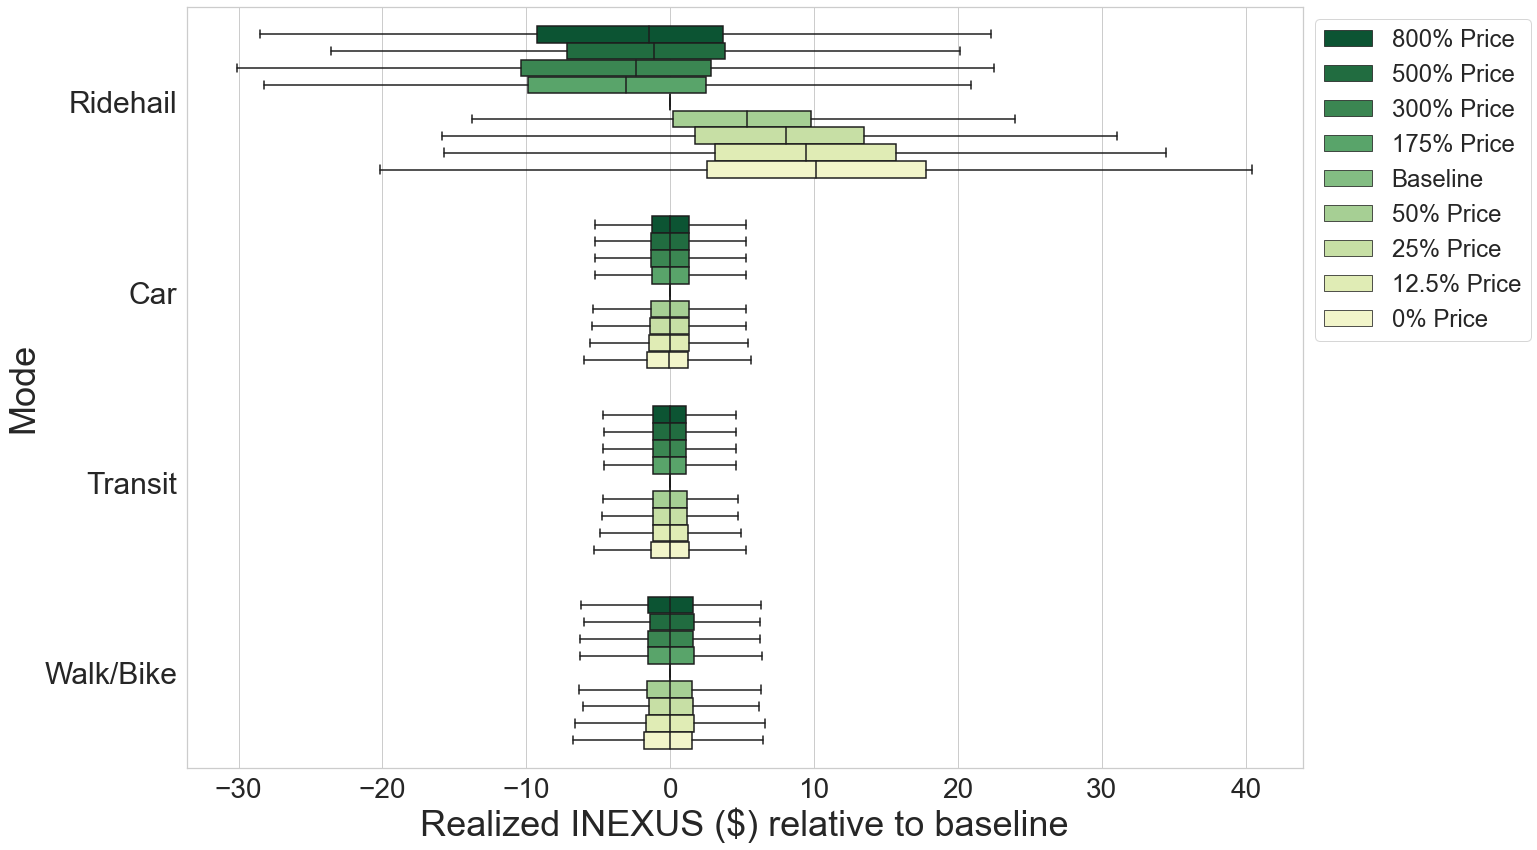

In [39]:
%%time
sns.set(rc={'figure.figsize':(20,14)})
sns.set_style("whitegrid", {'gridcolor': 'grainsboro'})
ax = sns.boxplot(x="realized_in_dollar_2023_relative_to_baseline", y="mode_choice_actual_4", order=["ride_hail","car","transit","walk/bike"], 
                 hue="lever_position_price", hue_order = [8, 5, 3, 1.75, 1, 0.5, 0.25, 0.125, 0],
                 data=same_mode_actual, palette="YlGn_r", showfliers=False)
ax.set_xlabel('Realized INEXUS ($) relative to baseline', fontsize = 36)
ax.set_ylabel('Mode', fontsize = 36)
ax.xaxis.set_tick_params(labelsize = 28)
ax.set_yticklabels(['Ridehail', 'Car','Transit','Walk/Bike'], size = 30)
handles, _ = ax.get_legend_handles_labels()
# Specify the order of the levels in the hue variable
hue_order = ['800% Price', '500% Price', '300% Price', '175% Price', 'Baseline', '50% Price', '25% Price', '12.5% Price', '0% Price']
# Create a dictionary that maps the levels of the hue variable to the corresponding colors in the palette
palette_dict = dict(zip(hue_order, sns.color_palette("rocket", n_colors=len(hue_order))))
# Create a new list of handles that corresponds to the order of the labels in the legend
handles = [handles[hue_order.index(label)] for label in hue_order]
# Use the new list of handles and the dictionary of colors to create the legend
ax.legend(handles, hue_order, loc="upper left", prop={'size': 24}, markerscale=3, fontsize=24, bbox_to_anchor=(1, 1))
plt.savefig('box_sameMode_realized_2023.svg', bbox_inches='tight', dpi=300)
plt.savefig('box_sameMode_realized_2023.png', bbox_inches='tight', dpi = 300)

#### Figure 8 - Income_Rank INEXUS plot

In [19]:
def process_income_data(dataframe):
    small_stacked_rh_price = dataframe[['lever_position_price','income_deciles','IDMerged','tripIndex',
                                        'income', 'realized_in_dollar_2023_relative_to_baseline', 
                                        'Realized_INEXUS_in_dollar_2023', 'potential_in_dollar_2023_relative_to_baseline',
                                        'Potential_INEXUS_in_dollar_2023', 'mode_choice_actual_4', 'duration_door_to_door',
                                        'waitTime_no_replanning','waitTime_replanning', 'mode_choice_planned_BEAM',
                                        'mode_choice_actual_BEAM','mode_actual_baseline']]
    
    small_stacked_rh_price['incomeInThousands'] = small_stacked_rh_price['income'] / 1000
    
    person_income = pd.pivot_table(
        small_stacked_rh_price,
        index=['IDMerged'],
        aggfunc={'incomeInThousands': lambda x: ', '.join(set(x.dropna().astype(str)))}).reset_index()
    
    person_income['incomeInThousands'] = person_income['incomeInThousands'].astype(float)
    
    twenty_one_ranks = person_income['incomeInThousands'].quantile([
        0, 0.048, 0.095, 0.143, 0.191, 0.239, 0.287, 0.335, 0.383, 0.431, 0.479,
        0.527, 0.575, 0.623, 0.671, 0.719, 0.767, 0.815, 0.863, 0.911, 0.959, 1
    ]).tolist()
    
    conditions = [
        (person_income['incomeInThousands'] >= twenty_one_ranks[i]) & 
        (person_income['incomeInThousands'] <= twenty_one_ranks[i+1])
        for i in range(21)
    ]
    
    choices = list(range(21))
    
    person_income['incomeRank'] = np.select(conditions, choices, default=None)
    
    smaller_stacked_rh_price = pd.merge(left = small_stacked_rh_price, right = person_income, how='left', on = ['IDMerged'], suffixes=('', '_drop'))
    smaller_stacked_rh_price.drop([col for col in smaller_stacked_rh_price.columns if 'drop' in col], axis=1, inplace=True)
    
    lorenz_data = pd.pivot_table(
        smaller_stacked_rh_price,
        index=['lever_position_price', 'incomeRank'],
        aggfunc={'incomeInThousands': np.mean,
                 'Potential_INEXUS_in_dollar_2023': np.mean,
                 'Realized_INEXUS_in_dollar_2023': np.mean,
                 'realized_in_dollar_2023_relative_to_baseline': np.mean,
                 'potential_in_dollar_2023_relative_to_baseline': np.mean}).reset_index() 
    return lorenz_data

In [21]:
lorenz_data = process_income_data(sf_stacked_rh_price)

C:\Users\nrezaei\AppData\Local\Temp\2\ipykernel_8268\2388425759.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_stacked_rh_price['incomeInThousands'] = small_stacked_rh_price['income'] / 1000


In [22]:
palette = {
    8: '#521e4d',
    5: '#8e1d5b',
    3: '#ad1759',
    1.75: '#ca1a50',
    1: '#e13243',
    0.5: '#ee543f',
    0.25: '#f37751',
    0.125: '#f5966d',
    0: '#f7d0b5'}

In [23]:
lorenz_data['incRank_percent'] = (lorenz_data['incomeRank'])*5

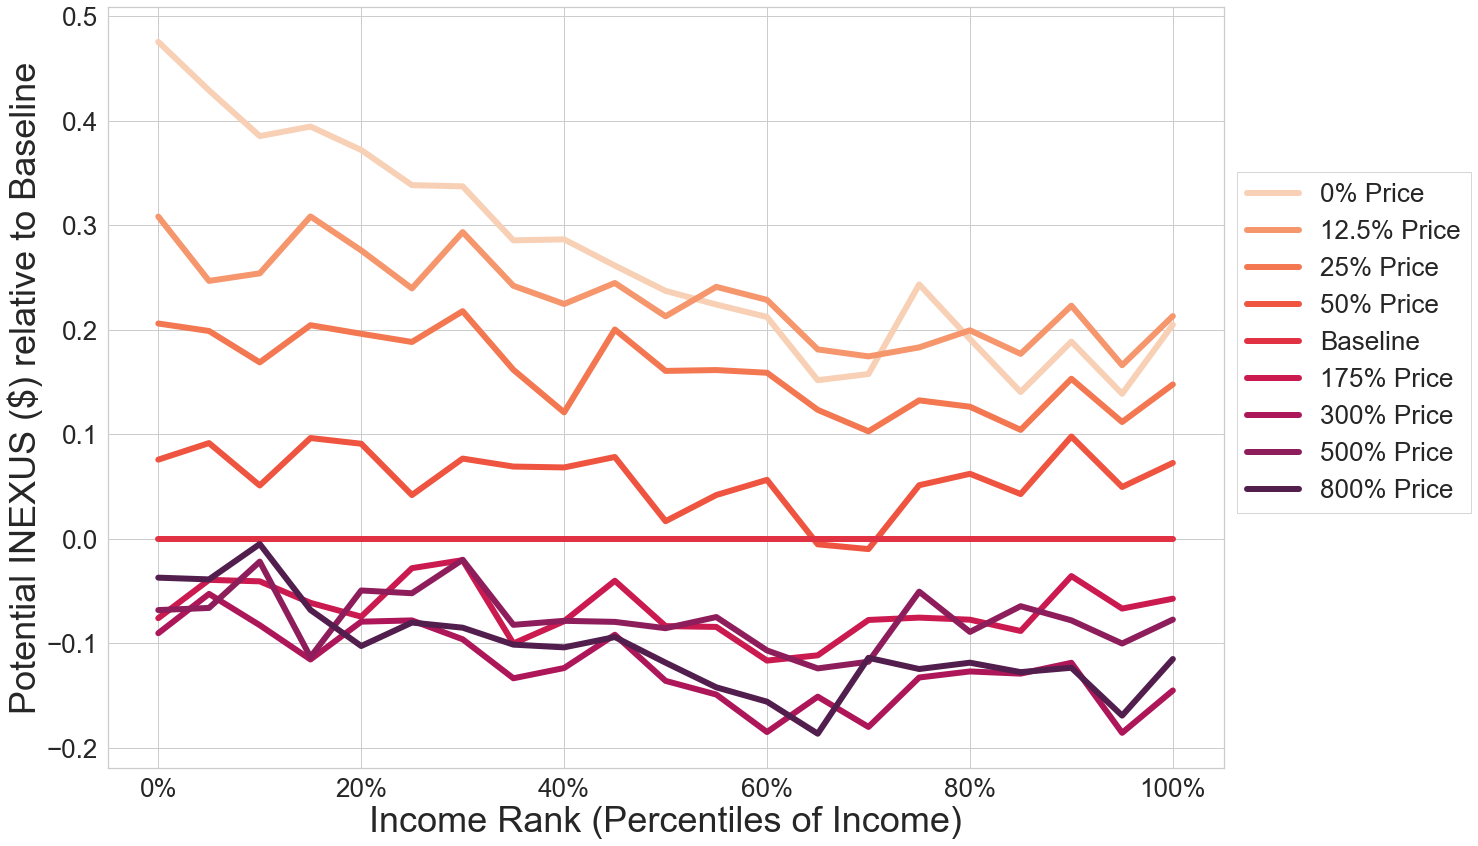

In [25]:
import matplotlib.ticker as ticker
sns.set(rc={'figure.figsize':(20,14)})
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots()
ax = sns.lineplot(data = lorenz_data, x = (lorenz_data['incomeRank'])*5, 
                  y = 'potential_in_dollar_2023_relative_to_baseline', hue = 'lever_position_price', palette = palette, ci=None, linewidth = 6)
ax.set_xlabel('Income Rank (Percentiles of Income)', fontsize = 36) #45
ax.set_ylabel('Potential INEXUS ($) relative to Baseline', fontsize = 36) #45
ax.yaxis.set_tick_params(labelsize = 26) #35
ax.xaxis.set_tick_params(labelsize = 26) #35
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{int(x)}%'))
plt.legend(labels = ['0% Price', '12.5% Price', '25% Price','50% Price','Baseline','175% Price','300% Price', '500% Price','800% Price'],
         fontsize='medium', fancybox=False, bbox_to_anchor=(1, 0.8), ncol=1, frameon=True, loc = 'best', prop={'size': 26}) #35
plt.savefig('lorenz.png', format='png', dpi=300, bbox_extra_artists=(ax.legend(['0% Price', '12.5% Price', '25% Price','50% Price','Baseline','175% Price','300% Price', '500% Price','800% Price'], fancybox=False, bbox_to_anchor=(1, 0.8), fontsize=26),), bbox_inches='tight') #30
#plt.savefig('lorenz.png', dpi=300)